In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ranksums
from decimal import Decimal
import math
import warnings
import statsmodels.api as sm
import os
import glob



# Format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 700)
sns.set(font_scale=1.1)  

# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=RuntimeWarning)


from matplotlib.cbook import boxplot_stats  # Para obtener los outliers en un boxplot
# boxplot_stats(df_blocks_filtered['antisaccade_errors']).pop(0)['fliers']


In [181]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    baseline_start=-200.0,
    baseline_end=100.0,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER=1.5,
    filter_by_block=False,
    selected_block=1,
    savgol_flag=False
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query("not webgazer_data.isnull() and isTutorial == False")

    # Le agrego numero de bloque al df
    blocks = sum([[i] * 20 for i in range(1, 17)], [])
    df_saccade.loc[:, "block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query("typeOfSaccade == @type_of_saccade")

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query("block == @selected_block")

    webgazer_data = df_saccade["webgazer_data"].map(eval)

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    ts_xs_ys = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ys = np.array([i["y"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # Interpolate
        if interpolate:
            fx = interp1d(ts, xs, kind="linear")
            fy = interp1d(ts, ys, kind="linear")
            samples = int((ts[-1] - (-200)) / 30) #  900 ms / 30 Hz te daria 30 samples
            ts_new = np.linspace(-200, ts[-1], samples)
            xs = fx(ts_new)
            ys = fy(ts_new)
            ts = ts_new

        # LOW_FILTER_PIX = 168 # Un 10% para cada lado
        # HIGH_FILTER_PIX = 1512 # Un 10% para cada lado
        # # filtro pasa banda de trials
        # if any(xs > HIGH_FILTER_PIX) or any(xs < LOW_FILTER_PIX):
        #     continue

        # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
        x_base = np.median(
            xs[(ts > baseline_start) & (ts < baseline_end)]
        )  # [-200, 100]

        y_base = np.median(
            ys[(ts > baseline_start) & (ts < baseline_end)]
        )  # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede antibar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts <= 700.0)])
        y_max = np.median(ys[(ts > 500.0) & (ts <= 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)
        ys = (ys - x_base) / np.abs(y_base - x_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y
        #  para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # # 6. Savitzky-Golay filter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        if savgol_flag:
            xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira
        xs_after_baseline = xs[ts > baseline_end]
        ts_after_baseline = ts[ts > baseline_end]
        if type_of_saccade == "prosaccade":
            is_sacc_error_in_trial = np.any(
                xs_after_baseline < -threshold_to_accept_sacc
            )
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1
                err_prosacc_idx = np.where(
                    xs_after_baseline < -threshold_to_accept_sacc
                )[0][0]
                err_prosacc_time = ts_after_baseline[err_prosacc_idx]
                pro_sacc_errors_rt.append(f"{err_prosacc_time:.2f}")
            else:
                corr_prosacc_idx = np.where(
                    xs_after_baseline >= threshold_to_accept_sacc
                )[0][0]
                corr_prosacc_time = ts_after_baseline[corr_prosacc_idx]
                pro_sacc_correct_rt.append(f"{corr_prosacc_time:.2f}")

        elif type_of_saccade == "antisaccade":
            is_anti_sacc_error_in_trial = np.any(
                xs_after_baseline > threshold_to_accept_sacc
            )
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1
                err_antisacc_idx = np.where(
                    xs_after_baseline > threshold_to_accept_sacc
                )[0][0]
                err_antisacc_time = ts_after_baseline[err_antisacc_idx]
                anti_sacc_errors_rt.append(f"{err_antisacc_time:.2f}")

            else:
                corr_antisacc_idx = np.where(
                    xs_after_baseline <= -threshold_to_accept_sacc
                )[0][0]
                corr_antisacc_time = ts_after_baseline[corr_antisacc_idx]
                anti_sacc_correct_rt.append(f"{corr_antisacc_time:.2f}")

        ts_xs_ys.append((ts, xs, ys))

    try:
        trials_rejected = 100 - (
            len(ts_xs_ys) / len(webgazer_data) * 100
        )  # len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs_ys)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs_ys)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan

    return {
        "ts_xs_ys": ts_xs_ys,
        "number_of_trials_remained": len(ts_xs_ys),
        "pro_sacc_errors": pro_sacc_errors,
        "pro_sacc_errors_perc": pro_saccades_errors_perc,
        "anti_sacc_errors": anti_sacc_errors,
        "anti_sacc_errors_perc": anti_saccades_errors_perc,
        "trials_rejected": trials_rejected,
        "pro_sacc_errors_rt": pro_sacc_errors_rt,
        "pro_sacc_correct_rt": pro_sacc_correct_rt,
        "anti_sacc_errors_rt": anti_sacc_errors_rt,
        "anti_sacc_correct_rt": anti_sacc_correct_rt,
        "age": int(eval(df["response"][1])["age"]),
        "px2degree": df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_width_pixels": df[~df["win_width_deg"].isna()]["win_width_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_height_pixels": df[~df["win_height_deg"].isna()]["win_height_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
    }


def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = (
            (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))
        ) + a
        values_normalized.append(res)
    return np.array(values_normalized)


def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(
        3, 1, height_ratios=[1, 4, 1], sharex=True, constrained_layout=True
    )

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinate predictions")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2)

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df["pro_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["pro_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2], height=0.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0], height=0.1)
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()
        axs[0].set_xlim([-200, 700])

    else:
        data_error = [float(i) for i in df["anti_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["anti_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0], height=0.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2], height=0.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    plt.suptitle(f"{type_of_saccade}")
    fig.align_ylabels(axs[:])
    fig.supxlabel("time (ms)")
    plt.show()

def calculate_distance(x_positions):
    distances = np.diff(x_positions)
    distance = np.sum(np.sqrt(distances ** 2))
    return distance

In [191]:
### TESTING SIMPLE

def pre_processing_simple(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    baseline_start=-200.0,
    baseline_end=100.0,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
    FILTER=1.5,
    filter_by_block=False,
    selected_block=1,
    savgol_flag=False
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`) y quedandome con las filas que tengan datos de webgazer
    df_saccade = df.query("not webgazer_data.isnull() and isTutorial == False")

    # Le agrego numero de bloque al df
    blocks = sum([[i] * 20 for i in range(1, 17)], [])
    df_saccade.loc[:, "block"] = blocks

    # Filtro por tipo de sacada
    df_saccade = df_saccade.query("typeOfSaccade == @type_of_saccade")

    # filtro por bloque
    if filter_by_block == True:
        df_saccade = df_saccade.query("block == @selected_block")

    webgazer_data = df_saccade["webgazer_data"].map(eval)

    pro_sacc_errors = 0
    anti_sacc_errors = 0

    ts_xs = []
    
    all_xs_baseline = []
    all_xs = []
    all_ts_baseline = []
    all_ts = []

    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    MIN_DISTANCE = 500

    all_x_base = []
    for state in ['first', 'second']:
        for trial in range(len(webgazer_data)):
            t0 = df_saccade["intraEnd"].iloc[trial]
            tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
            xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
            ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

            # Interpolate
            if interpolate:
                f1 = interp1d(ts, xs, kind="linear")
                samples = int((ts[-1] - (-200)) / 30) #  900 ms / 30 Hz te daria 30 samples
                ts_new = np.linspace(-200, ts[-1], samples)
                xs = f1(ts_new)
                ts = ts_new

            # 1. Calcular la mediana entre [baseline_start baseline_end] = Xbase
            x_base = np.median(
                xs[(ts > baseline_start) & (ts < baseline_end)]
            )  # [-200, 100]

            if state == 'first':
                all_x_base.append(x_base)

            if state == 'second':
                std_x_base = np.std(all_x_base)
                mean_plus_std = np.mean(all_x_base) + std_x_base * 2
                mean_minus_std = np.mean(all_x_base) - std_x_base * 2
                distance = calculate_distance(np.array(xs))

                # Filter1: If the value of x_base is outside the range of mean_plus_std or mean_minus_std
                if (x_base >  mean_plus_std) or (x_base <  mean_minus_std) :
                    print("filtro")
                    print("x_base:", x_base)
                    print("mean_plus_std:", mean_plus_std)
                    print("mean_minus_std:", mean_minus_std)
                    continue
                # Filter 2: Distance traveled
                elif distance < MIN_DISTANCE:
                    print(f"FILTER: Distance: {distance} < minimun distance:{MIN_DISTANCE}")
                    continue
                else:
                    print("NO FILTRO")
                    # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
                    # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
                    # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
                    # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y
                    #  para abajo en la direccion opuesta
                    if df_saccade["cueShownAtLeft"].iloc[trial] == True:
                        xs = xs * -1

                    # # 5. filtro pasa banda de trials
                    # if any(xs > FILTER) or any(xs < -FILTER):
                    #     continue164.61468164266267

                    # # 6. Savitzky-Golay filter
                    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
                    # if savgol_flag:
                    #     xs = savgol_filter(xs, 5, 2)

                    # 7. Detectar lado en que mira
                    xs_after_baseline = xs[ts > baseline_end]
                    ts_after_baseline = ts[ts > baseline_end]
            
                    all_xs_baseline.append(xs_after_baseline)
                    all_xs.append(xs)
                    all_ts_baseline.append(ts_after_baseline)
                    all_ts.append(ts)
                    ts_xs.append((ts, xs))

    try:
        trials_rejected = 100 - (
            len(ts_xs) / len(webgazer_data) * 100
        )  # len(webgazer_data) = 160 siempre
        pro_saccades_errors_perc = (pro_sacc_errors / len(ts_xs)) * 100
        anti_saccades_errors_perc = (anti_sacc_errors / len(ts_xs)) * 100
    except ZeroDivisionError:
        trials_rejected = 100
        pro_saccades_errors_perc = np.nan
        anti_saccades_errors_perc = np.nan
    
    return {
        "ts_xs": ts_xs,
        "number_of_trials_remained": len(ts_xs),
        "all_xs_baseline": all_xs_baseline,
        "all_xs": all_xs,
        "all_ts_baseline": all_ts_baseline,
        "all_ts": all_ts,
        # "pro_sacc_errors": pro_sacc_errors,
        # "pro_sacc_errors_perc": pro_saccades_errors_perc,
        # "anti_sacc_errors": anti_sacc_errors,
        # "anti_sacc_errors_perc": anti_saccades_errors_perc,
        # "trials_rejected": trials_rejected,
        # "pro_sacc_errors_rt": pro_sacc_errors_rt,
        # "pro_sacc_correct_rt": pro_sacc_correct_rt,
        # "anti_sacc_errors_rt": anti_sacc_errors_rt,
        # "anti_sacc_correct_rt": anti_sacc_correct_rt,
        "age": int(eval(df["response"][1])["age"]),
        "px2degree": df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_width_pixels": df[~df["win_width_deg"].isna()]["win_width_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "win_height_pixels": df[~df["win_height_deg"].isna()]["win_height_deg"].iloc[0].round(2)
        * df[~df["px2deg"].isna()]["px2deg"].iloc[0].round(2),
        "all_x_base": all_x_base
    }

def one_subject(df, suj_number, type_of_saccade):
    fig, axs = plt.subplots(
        3, 1, height_ratios=[1, 4, 1], sharex=True, constrained_layout=True
    )

    suj_number = str(suj_number)
    print("suj_number:", suj_number)
    df = df.query("subject == @suj_number")
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        axs[1].plot(ts, xs)

        axs[1].axhline(y=0.5, color="k", linestyle="-")
        axs[1].axhline(y=-0.5, color="k", linestyle="-")
        axs[1].axvline(x=0, color="k", linestyle="-")
        axs[1].set_ylabel("x coordinate predictions")
        # axs[1].set_xlabel("time (ms)")
        axs[1].set_xticks(np.arange(-200, 1000, step=100))
        axs[1].set_xlim(-200, 700)
        axs[1].set_ylim(-2, 2) 

    if type_of_saccade == "prosaccade":
        data_error = [float(i) for i in df["pro_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["pro_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[2])
        sns.rugplot(data_error, ax=axs[2], height=0.1)
        sns.kdeplot(data_correct, ax=axs[0])
        sns.rugplot(data_correct, ax=axs[0], height=0.1)
        axs[2].set_xlim([-200, 700])
        axs[0].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    else:
        data_error = [float(i) for i in df["anti_sacc_errors_rt"].iloc[0]]
        data_correct = [float(i) for i in df["anti_sacc_correct_rt"].iloc[0]]
        sns.kdeplot(data_error, ax=axs[0])
        sns.rugplot(data_error, ax=axs[0], height=0.1)
        sns.kdeplot(data_correct, ax=axs[2])
        sns.rugplot(data_correct, ax=axs[2], height=0.1)
        axs[0].set_xlim([-200, 700])
        axs[2].set_xlim([-200, 700])
        axs[2].invert_yaxis()

    plt.suptitle(f"{type_of_saccade}")
    fig.align_ylabels(axs[:])
    fig.supxlabel("time (ms)")
    plt.show()


### Load all files without block separation (simplified version)

In [192]:
# SIMPLIFIED VERSION
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))


df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
pro_saccades_errors_perc = []
anti_saccades_errors = []
anti_saccades_errors_perc = []
trials_rejected_prosaccade = []
trials_rejected_antisaccade = []
pro_sacc_errors_rt = []
pro_sacc_correct_rt = []
anti_sacc_errors_rt = []
anti_sacc_correct_rt = []
prosaccade_trials_remained = []
antisaccade_trials_remained = []
age = []
px2degree = []
win_height_pixels = []
win_width_pixels = []

pro_all_xs_baseline = []
pro_all_xs = []
pro_all_ts_baseline = []
pro_all_ts = []

anti_all_xs_baseline = []
anti_all_xs = []
anti_all_ts_baseline = []
anti_all_ts = []

print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_saccade_dict = pre_processing_simple(
        df, type_of_saccade="antisaccade", interpolate=True
    )
    pro_saccade_dict = pre_processing_simple(
        df, type_of_saccade="prosaccade", interpolate=True
    )
    subjects.append(suj)
    pro_saccades.append(pro_saccade_dict["ts_xs"])
    prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
    antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    anti_saccades.append(anti_saccade_dict["ts_xs"])
    

    age.append(anti_saccade_dict["age"])
    px2degree.append(pro_saccade_dict["px2degree"])
    win_height_pixels.append(pro_saccade_dict["win_height_pixels"])
    win_width_pixels.append(pro_saccade_dict["win_width_pixels"])

    pro_all_xs_baseline.append(pro_saccade_dict['all_xs_baseline'])
    pro_all_xs.append(pro_saccade_dict["all_xs"])
    pro_all_ts_baseline.append(pro_saccade_dict["all_ts_baseline"])
    pro_all_ts.append(pro_saccade_dict['all_ts'])

    anti_all_xs_baseline.append(anti_saccade_dict['all_xs_baseline'])
    anti_all_xs.append(anti_saccade_dict["all_xs"])
    anti_all_ts_baseline.append(anti_saccade_dict["all_ts_baseline"])
    anti_all_ts.append(anti_saccade_dict['all_ts'])
    

    # print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades

df_processed_signal["pro_all_xs_baseline"] = pro_all_xs_baseline
df_processed_signal["pro_all_xs"] = pro_all_xs
df_processed_signal["pro_all_ts_baseline"] = pro_all_ts_baseline
df_processed_signal["pro_all_ts"] = pro_all_ts

df_processed_signal["anti_all_xs_baseline"] = anti_all_xs_baseline
df_processed_signal["anti_all_xs"] = anti_all_xs
df_processed_signal["anti_all_ts_baseline"] = anti_all_ts_baseline
df_processed_signal["anti_all_ts"] = anti_all_ts
df_processed_signal["age"] = age
df_processed_signal["px2degree"] = px2degree
df_processed_signal["win_width_pixels"] = win_width_pixels
df_processed_signal["win_height_pixels"] = win_height_pixels

print(" ")
print("✅df_processed_signal ready✅")

processing ...
raw_data/antisacadas_99.csv
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
filtro
x_base: 333.24915824915826
mean_plus_std: 1231.0096867377315
mean_minus_std: 572.5509601670809
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
filtro
x_base: 354.6136363636364
mean_plus_std: 1231.0096867377315
mean_minus_std: 572.5509601670809
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO FILTRO
NO F

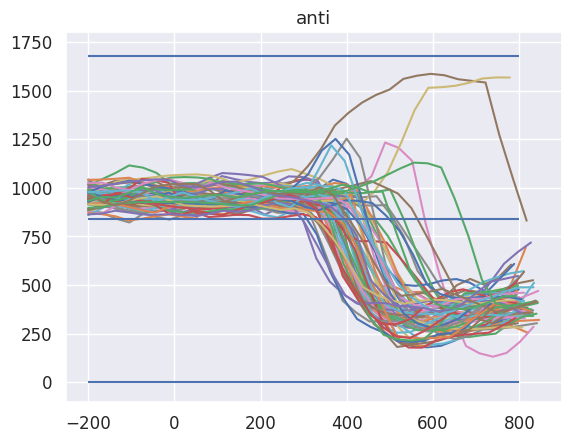

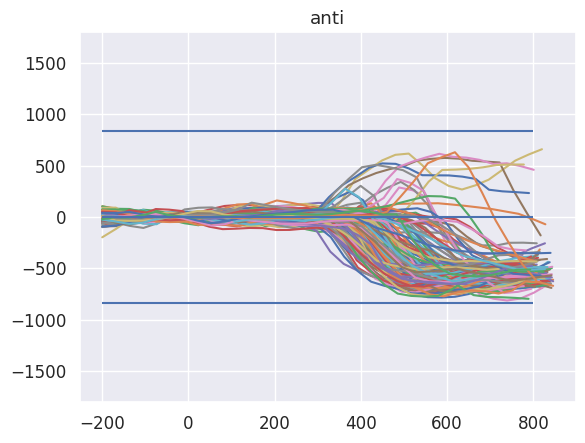

In [194]:
# trials_xs = df_processed_signal['pro_all_xs_baseline'][0]
# trials_ts = df_processed_signal['pro_all_ts_baseline'][0]

# plt.plot(trials_ts[0], trials_xs[0])
# plt.show()

suj = 1
type_of_sacc = 'anti'

trials_xs = df_processed_signal[f'{type_of_sacc}_all_xs'][suj]
trials_ts = df_processed_signal[f'{type_of_sacc}_all_ts'][suj]
pxs2deg = df_processed_signal.iloc[suj]['px2degree']

for trial in range(len(trials_xs)):

    x_base = np.median(trials_xs[trial][(trials_ts[trial] > -200) & (trials_ts[trial] < 100)])
    trial_xs_bl = trials_xs[trial] - x_base
    plt.plot(trials_ts[trial], trials_xs[trial])

plt.ylim(-100, 1800)
plt.hlines(840, -200, 800)
plt.hlines(0, -200, 800)
plt.hlines(1680, -200, 800)
plt.title(type_of_sacc)
plt.show()

for trial in range(len(trials_xs)):

    x_base = np.median(trials_xs[trial][(trials_ts[trial] > -200) & (trials_ts[trial] < 100)])
    trial_xs_bl = trials_xs[trial] - x_base
    plt.plot(trials_ts[trial], trial_xs_bl)

plt.ylim(-1800, 1800)
plt.hlines(-840, -200, 800)
plt.hlines(840, -200, 800)
plt.hlines(0, -200, 800)
plt.title(type_of_sacc)
plt.show()

In [198]:
df_processed_signal['px2degree'].mean()

34.46846153846154

In [201]:
(np.arctan(30/50) * 180) / np.pi

30.96375653207352

In [199]:
1000 / 34

29.41176470588235

In [ ]:
df_processed_signal[['trials_rejected_prosaccade_percentage','trials_rejected_antisaccade_percentage']].boxplot(rot=45)
print(df_processed_signal['trials_rejected_prosaccade_percentage'].median())
print(df_processed_signal['trials_rejected_antisaccade_percentage'].median())

plt.title(f"""

trials_rejected_prosaccade_percentage : {df_processed_signal['trials_rejected_prosaccade_percentage'].mean():.3f} +- {df_processed_signal['trials_rejected_prosaccade_percentage'].std():.3f}
trials_rejected_antisaccade_percentage : {df_processed_signal['trials_rejected_antisaccade_percentage'].mean():.3f} +- {df_processed_signal['trials_rejected_antisaccade_percentage'].std():.3f}

""")

### Load all files and separate in blocks


In [81]:
# SEPARACION EN BLOQUES

ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
REJECTED_SUJ = []
all_dfs = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    df = pd.read_csv(suj)
    if suj in REJECTED_SUJ:
        continue
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]

    _df_processed_signal = pd.DataFrame(
        {
            "subject": None,
            "prosaccade": None,
            "antisaccade": None,
            "prosaccade_errors": None,
            "antisaccade_errors": None,
        },
        index=[],
    )

    subjects = []
    prosaccade_trials_remained = []
    antisaccade_trials_remained = []
    pro_saccades = []
    anti_saccades = []
    pro_saccades_errors = []
    pro_saccades_errors_perc = []

    anti_saccades_errors = []
    anti_saccades_errors_perc = []
    trials_rejected_prosaccade = []
    trials_rejected_antisaccade = []
    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []
    age = []
    px2degree = []
    block_number = []

    print(suj)


    for block in range(1, 17):
        anti_saccade_dict = pre_processing(
            df,
            type_of_saccade="antisaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block,
        )
        pro_saccade_dict = pre_processing(
            df,
            type_of_saccade="prosaccade",
            interpolate=True,
            filter_by_block=True,
            selected_block=block
        )
        subjects.append(suj)
        pro_saccades.append(pro_saccade_dict["ts_xs_ys"])
        anti_saccades.append(anti_saccade_dict["ts_xs_ys"])

        prosaccade_trials_remained.append(pro_saccade_dict["number_of_trials_remained"])
        antisaccade_trials_remained.append(anti_saccade_dict["number_of_trials_remained"])
    
        pro_saccades_errors.append(pro_saccade_dict["pro_sacc_errors"])
        pro_saccades_errors_perc.append(pro_saccade_dict["pro_sacc_errors_perc"])
        anti_saccades_errors.append(anti_saccade_dict["anti_sacc_errors"])
        anti_saccades_errors_perc.append(anti_saccade_dict["anti_sacc_errors_perc"])
        trials_rejected_prosaccade.append(pro_saccade_dict["trials_rejected"])
        trials_rejected_antisaccade.append(anti_saccade_dict["trials_rejected"])
        pro_sacc_errors_rt.append(pro_saccade_dict["pro_sacc_errors_rt"])
        pro_sacc_correct_rt.append(pro_saccade_dict["pro_sacc_correct_rt"])
        anti_sacc_errors_rt.append(anti_saccade_dict["anti_sacc_errors_rt"])
        anti_sacc_correct_rt.append(anti_saccade_dict["anti_sacc_correct_rt"])
        age.append(anti_saccade_dict["age"])
        px2degree.append(pro_saccade_dict["px2degree"])
        block_number.append(block)
        # print(" --- ")

    _df_processed_signal["subject"] = subjects
    _df_processed_signal["prosaccade"] = pro_saccades
    _df_processed_signal["antisaccade"] = anti_saccades
    _df_processed_signal["prosaccade_errors"] = pro_saccades_errors
    _df_processed_signal["antisaccade_errors"] = anti_saccades_errors
    _df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
        pro_saccades_errors
    )
    _df_processed_signal[
        "trials_rejected_antisaccade_percentage"
    ] = trials_rejected_antisaccade
    _df_processed_signal[
        "trials_rejected_prosaccade_percentage"
    ] = trials_rejected_prosaccade
    _df_processed_signal["pro_sacc_errors_rt"] = pro_sacc_errors_rt
    _df_processed_signal["pro_sacc_correct_rt"] = pro_sacc_correct_rt
    _df_processed_signal["anti_sacc_errors_rt"] = anti_sacc_errors_rt
    _df_processed_signal["anti_sacc_correct_rt"] = anti_sacc_correct_rt

    # median
    _df_processed_signal["pro_sacc_errors_rt_median"] = _df_processed_signal[
        "pro_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["pro_sacc_correct_rt_median"] = _df_processed_signal[
        "pro_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_errors_rt_median"] = _df_processed_signal[
        "anti_sacc_errors_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))
    _df_processed_signal["anti_sacc_correct_rt_median"] = _df_processed_signal[
        "anti_sacc_correct_rt"
    ].apply(lambda x: np.median([float(i) for i in x]))

    # Percentage of errors
    _df_processed_signal["prosaccade_errors_perc"] = pro_saccades_errors_perc
    _df_processed_signal["antisaccade_errors_perc"] = anti_saccades_errors_perc

    _df_processed_signal["prosaccade_trials_remained"] = prosaccade_trials_remained
    _df_processed_signal["antisaccade_trials_remained"] = antisaccade_trials_remained


    _df_processed_signal["age"] = age
    _df_processed_signal["px2degree"] = px2degree
    _df_processed_signal['block'] = block_number


    all_dfs.append(_df_processed_signal)

print(" ")

df_all_blocks = pd.concat(all_dfs)

print("df_all_blocks ready✅")

processing ...
99
110
124
115
91
101
104
102
92
107
105
112
98
113
100
118
127
123
109
126
103
114
125
117
111
119
 
df_all_blocks ready✅


In [60]:
df_all_blocks.head()

,subject,prosaccade,antisaccade,prosaccade_errors,antisaccade_errors,delta_errors,trials_rejected_antisaccade_percentage,trials_rejected_prosaccade_percentage,pro_sacc_errors_rt,pro_sacc_correct_rt,anti_sacc_errors_rt,anti_sacc_correct_rt,pro_sacc_errors_rt_median,pro_sacc_correct_rt_median,anti_sacc_errors_rt_median,anti_sacc_correct_rt_median,prosaccade_errors_perc,antisaccade_errors_perc,prosaccade_trials_remained,antisaccade_trials_remained,age,px2degree,block
0,99,"[([-200.0, -168.1875, -136.375, -104.5625, -72...",[],1,0,-1,100.0,10.0,[368.45],"[531.69, 520.91, 396.12, 421.21, 429.09, 425.4...",[],[],368.45,425.45,NaN,NaN,5.555556,NaN,18,0,35,29.22,1
1,99,[],"[([-200.0, -168.34375, -136.6875, -105.03125, ...",0,1,1,15.0,100.0,[],[],[367.00],"[401.47, 462.45, 497.12, 485.44, 402.06, 545.4...",NaN,NaN,367.00,473.945,NaN,5.882353,0,17,35,29.22,2
2,99,"[([-200.0, -168.66666666666666, -137.333333333...",[],1,0,-1,100.0,5.0,[276.13],"[364.00, 424.38, 461.50, 403.25, 558.25, 428.7...",[],[],276.13,400.28,NaN,NaN,5.263158,NaN,19,0,35,29.22,3
3,99,[],"[([-200.0, -168.28125, -136.5625, -104.84375, ...",0,2,2,0.0,100.0,[],[],"[434.38, 268.64]","[449.73, 461.50, 491.23, 514.44, 418.79, 426.0...",NaN,NaN,351.51,435.935,NaN,10.000000,0,20,35,29.22,4
4,99,"[([-200.0, -168.15625, -136.3125, -104.46875, ...",[],1,0,-1,100.0,15.0,[337.09],"[564.25, 406.16, 363.06, 365.64, 425.62, 429.3...",[],[],337.09,405.30,NaN,NaN,5.882353,NaN,17,0,35,29.22,5


### Filtering blocks

In [82]:
# Constants
MAX_NUMBER_INCORRECTS_BY_BLOCK = (
    10  # Esto implica que en un bloque hizo al menos el 50% mal
)
FIRST_BLOCK = 1
LAST_BLOCK = 16

# Filter
df_blocks_filtered = (
    df_all_blocks.query(
        "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
    )  # Con la mitad de los bloques
    .groupby("subject")
    .agg(
        {
            "prosaccade": list,
            "antisaccade": list,
            "prosaccade_errors": "sum",
            "antisaccade_errors": "sum",
            "prosaccade_trials_remained": "sum",
            "antisaccade_trials_remained": "sum",
            "pro_sacc_errors_rt": "sum",
            "pro_sacc_correct_rt": "sum",
            "anti_sacc_errors_rt": "sum",
            "anti_sacc_correct_rt": "sum",
            "pro_sacc_errors_rt_median": np.nanmean,
            "anti_sacc_errors_rt_median": np.nanmean,
            "pro_sacc_correct_rt_median": np.nanmean,
            "anti_sacc_correct_rt_median": np.nanmean,
            "block": lambda x: x.nunique(),
            "age": pd.Series.mode,  # TODO: MAKE THE SAME WITH OTHER SIMILAR DATA
            "px2degree": pd.Series.mode,
        }
    )
)

df_blocks_filtered = df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)
df_blocks_filtered["max_number_incorrect_by_block"] = MAX_NUMBER_INCORRECTS_BY_BLOCK
df_blocks_filtered.insert(
    2,
    "delta_errors",
    df_blocks_filtered["antisaccade_errors"] - df_blocks_filtered["prosaccade_errors"],
)


# Percentage
df_blocks_filtered["prosaccade_errors_perc"] = (
    df_blocks_filtered["prosaccade_errors"]
    / df_blocks_filtered["prosaccade_trials_remained"]
) * 100


df_blocks_filtered["antisaccade_errors_perc"] = (
    df_blocks_filtered["antisaccade_errors"]
    / df_blocks_filtered["antisaccade_trials_remained"]
) * 100

# Data wrangling
prosaccs_all = []
antisaccs_all = []
for suj in range(len(df_blocks_filtered)):
    prosaccs_one_suj = []
    antisaccs_one_suj = []
    prosaccades = df_blocks_filtered.iloc[suj]["prosaccade"]
    antisaccades = df_blocks_filtered.iloc[suj]["antisaccade"]
    for block_pro in prosaccades:
        if block_pro:
            for trial in block_pro:
                prosaccs_one_suj.append(trial)

    for block_anti in prosaccades:
        if block_anti:
            for trial in block_anti:
                antisaccs_one_suj.append(trial)

    prosaccs_all.append(prosaccs_one_suj)
    antisaccs_all.append(antisaccs_one_suj)

df_blocks_filtered["prosaccade"] = prosaccs_all
df_blocks_filtered["antisaccade"] = antisaccs_all

print("df_blocks_filtered ready ✅")


df_blocks_filtered ready ✅


0.0871
N=26, blocks=16
Cantidad de bloques filtrados: 3


Text(0.5, 1.0, '\nPercentage of incorrect trials\nN suj = 26\nblocks = 16\np_value = 0.0871\n')

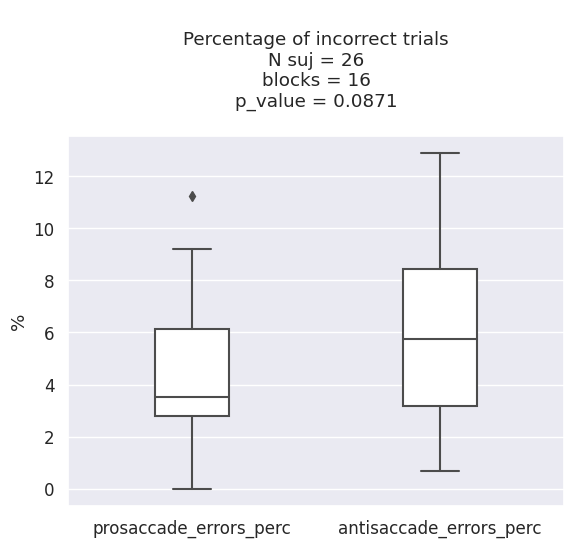

In [83]:
# Plot errors

ax = sns.boxplot(
    data=df_blocks_filtered[["prosaccade_errors_perc", "antisaccade_errors_perc"]],
    width=0.3,
)
ax.set_ylabel("%")

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")


p_value = round((
    ranksums(
        df_blocks_filtered["prosaccade_errors_perc"],
        df_blocks_filtered["antisaccade_errors_perc"],
    )[1]
), 4)

print(p_value)
print(f"N={len(df_blocks_filtered)}, blocks={df_blocks_filtered['remained_blocks'].max()}")

print(f"Cantidad de bloques filtrados: {(len(df_blocks_filtered['remained_blocks']) * 16)  - df_blocks_filtered['remained_blocks'].sum()}")

df_blocks_filtered.describe()

plt.title(f"""
Percentage of incorrect trials
N suj = {len(df_blocks_filtered)}
blocks = {df_blocks_filtered['remained_blocks'].max()}
p_value = {p_value}
""")

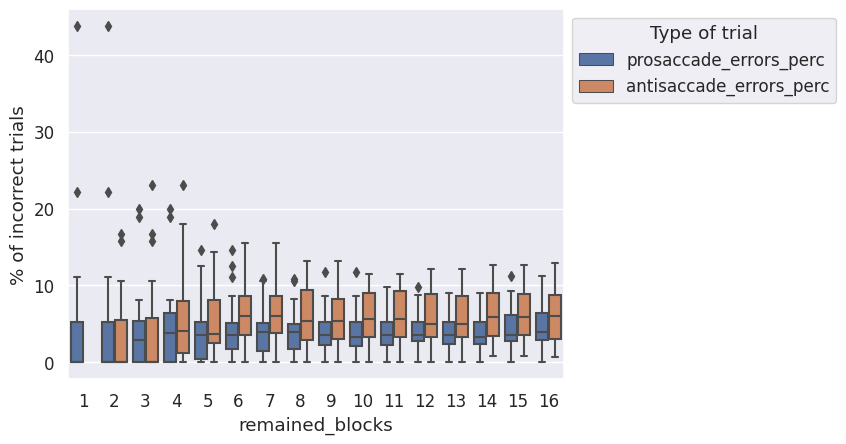

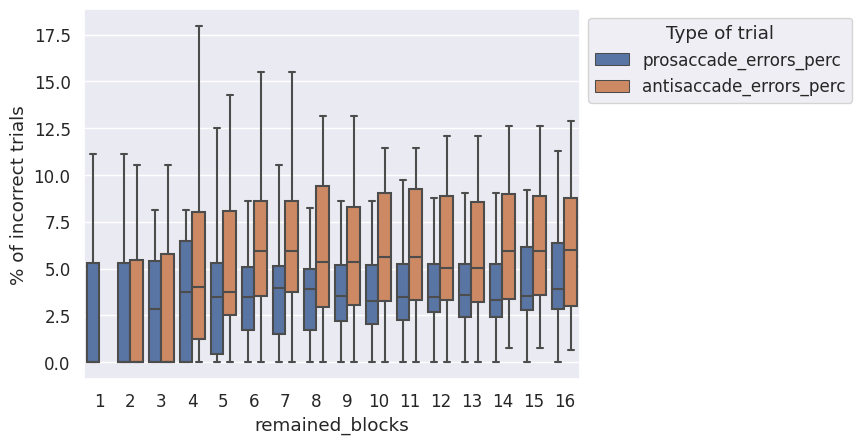

In [85]:
# Incorrectos por bloque
all_dfs = []
for last_block in range(1, 17):
    # filtrar bloques

    FIRST_BLOCK = 1
    LAST_BLOCK = last_block

    _df_blocks_filtered = (
        df_all_blocks.query(
            "prosaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and antisaccade_errors < @MAX_NUMBER_INCORRECTS_BY_BLOCK and @FIRST_BLOCK <= block <= @LAST_BLOCK"
        )  # Con la mitad de los bloques
        .groupby("subject")
        .agg(
            {
                "prosaccade_errors": "sum",
                "antisaccade_errors": "sum",
                "prosaccade_trials_remained": "sum",
                "antisaccade_trials_remained": "sum",
                "pro_sacc_errors_rt": "sum",
                "pro_sacc_correct_rt": "sum",
                "anti_sacc_errors_rt": "sum",
                "anti_sacc_correct_rt": "sum",
                "pro_sacc_errors_rt_median": np.nanmean,
                "anti_sacc_errors_rt_median": np.nanmean,
                "pro_sacc_correct_rt_median": np.nanmean,
                "anti_sacc_correct_rt_median": np.nanmean,
                "block": lambda x: x.nunique(),
            }
        )
    )

    _df_blocks_filtered = _df_blocks_filtered.rename({"block": "remained_blocks"}, axis=1)


    # Percentage
    _df_blocks_filtered["prosaccade_errors_perc"] = (
        _df_blocks_filtered["prosaccade_errors"]
        / _df_blocks_filtered["prosaccade_trials_remained"]
    ) * 100


    _df_blocks_filtered["antisaccade_errors_perc"] = (
        _df_blocks_filtered["antisaccade_errors"]
        / _df_blocks_filtered["antisaccade_trials_remained"]
    ) * 100
    all_dfs.append(_df_blocks_filtered)

all_dataframes = pd.concat(all_dfs)

all_dataframes

# Plot
ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ax = sns.boxplot(
    data=all_dataframes.melt(id_vars=['remained_blocks'], value_vars=['prosaccade_errors_perc', 'antisaccade_errors_perc'],
                 var_name='Type of trial', value_name='% of incorrect trials'),
    x='remained_blocks',
    y='% of incorrect trials',
    hue='Type of trial',
    showfliers = False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()

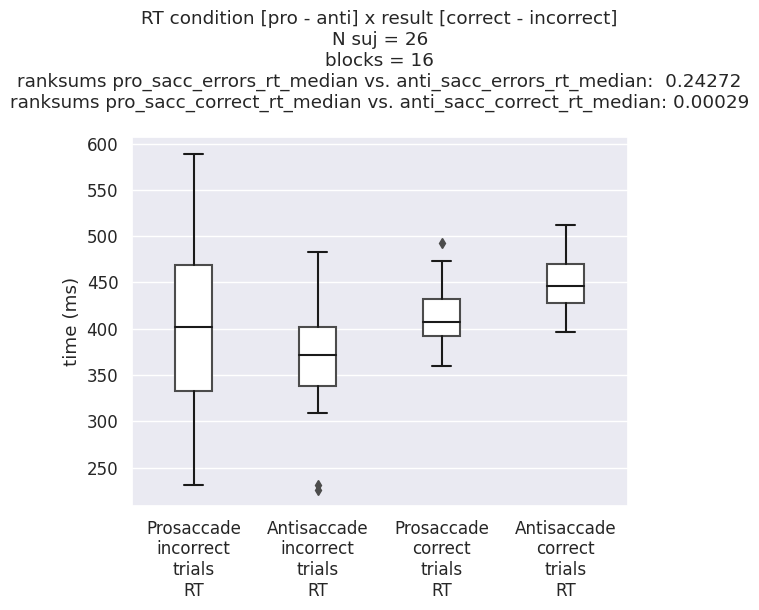

In [87]:
# RT VERSION CON BLOQUES

# Boxplot with means
ax = sns.boxplot(
    data=df_blocks_filtered[
        [
            "pro_sacc_errors_rt_median",
            "anti_sacc_errors_rt_median",
            "pro_sacc_correct_rt_median",
            "anti_sacc_correct_rt_median",
        ]
    ],
    width=0.3,
)

boxes = ax.patches

for i, box in enumerate(boxes):
    box.set_facecolor("w")

plt.ylabel("time (ms)")
ax.set_xticklabels(
    [
        "Prosaccade\nincorrect\ntrials\nRT",
        "Antisaccade\nincorrect\ntrials\nRT",
        "Prosaccade\ncorrect\ntrials\nRT",
        "Antisaccade\ncorrect\ntrials\nRT",
    ]
)

plt.setp(ax.artists, edgecolor="k", facecolor="w")
plt.setp(ax.lines, color="k")


title = (
    f"""RT condition [pro - anti] x result [correct - incorrect]
N suj = {len(df_blocks_filtered)}
blocks = {df_blocks_filtered['remained_blocks'].max()}
ranksums pro_sacc_errors_rt_median vs. anti_sacc_errors_rt_median:  {Decimal(ranksums(df_blocks_filtered['pro_sacc_errors_rt_median'],df_blocks_filtered['anti_sacc_errors_rt_median'], nan_policy='omit')[1]):.5f}
ranksums pro_sacc_correct_rt_median vs. anti_sacc_correct_rt_median: {Decimal(ranksums(df_blocks_filtered['pro_sacc_correct_rt_median'],df_blocks_filtered['anti_sacc_correct_rt_median'], nan_policy='omit')[1]):.5f}
"""
)

df_blocks_filtered.describe()

plt.title(title)
plt.show()

### PLOT EYE DATA

In [ ]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split("/")[-1].split(".")[0].split("_")[-1]
    print(suj)
    one_subject(df_blocks_filtered, suj, "prosaccade")
    one_subject(df_blocks_filtered, suj, "antisaccade")

### Saccade detection


### Preparing test dataset

`infile`: Data file with eye gaze recordings to process. <br>
The first two columns in this file must contain x and y coordinates, while each line is a timepoint (no header). <br>
The file is read with NumPy's recfromcsv and may be compressed. The columns are expected to be seperated by tabulators (\t).

In [88]:
for data in df_blocks_filtered.iloc[0]['prosaccade']:
    print(data)
    break

(array([-200.     , -168.53125, -137.0625 , -105.59375,  -74.125  ,
        -42.65625,  -11.1875 ,   20.28125,   51.75   ,   83.21875,
        114.6875 ,  146.15625,  177.625  ,  209.09375,  240.5625 ,
        272.03125,  303.5    ,  334.96875,  366.4375 ,  397.90625,
        429.375  ,  460.84375,  492.3125 ,  523.78125,  555.25   ,
        586.71875,  618.1875 ,  649.65625,  681.125  ,  712.59375,
        744.0625 ,  775.53125,  807.     ]), array([ 4.23743330e-02, -1.39575164e-02,  7.60606578e-02,  6.62238284e-02,
        3.64841974e-03, -1.31008523e-02, -5.43217239e-03, -2.42146876e-03,
       -0.00000000e+00,  1.66215929e-03, -3.87531595e-02, -6.19842978e-02,
       -2.44390527e-02,  7.34717323e-04, -8.75591843e-02, -1.75853086e-01,
       -1.00618243e-01,  5.42129804e-02,  3.08906927e-01,  5.67785331e-01,
        8.03624106e-01,  9.82950136e-01,  1.10488363e+00,  1.14709974e+00,
        1.06193715e+00,  9.75303302e-01,  9.91049686e-01,  9.97698323e-01,
        1.00230168e+00,  1.

### Analisis trial por trial

In [89]:

# Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
# OUT_FOLDER = "./pro_saccade_detection_by_trial/"
OUT_FOLDER = "./saccade_detection/"
SFREQ = 30  # Sampling rate after inteporlation
TYPE_OF_SACCADE = "prosaccade"

for SUJ in range(len(df_blocks_filtered)):
    for trial_num, data in enumerate(df_blocks_filtered.iloc[SUJ][TYPE_OF_SACCADE]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial_num}")
        rows = []
        # Remodnav parameters
        FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial_{trial_num}.csv"
        PX2DEG = df_blocks_filtered["px2degree"][SUJ]
        OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial_{trial_num}.tsv"
        t_samples = data[0]
        x_samples = data[1]
        y_samples = data[2]

        # create a new row as a dictionary
        new_row = {
            "x": x_samples,
            "y": y_samples,
            "t": t_samples,
            "trial": trial_num,
        }
        rows.append(new_row)

        df_sacc = pd.DataFrame(rows)
        df_sacc = df_sacc.explode(["x", "y", "t"], ignore_index=True)
        df_sacc = df_sacc[["x", "y"]]

        # One trial data
        samples = len(x_samples)
        df_sacc.iloc[:samples + 2].to_csv(
            OUT_FOLDER + FNAME, sep="\t", header=False, index=False
        )

        print("\nRunning saccades and fixations detection")

        # Run Remodnav not considering pursuit class and min fixations 100 ms
        command = (
            f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
            f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
        )
        os.system(command)
    break
    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")


Suj: 100, trial: 0

Running saccades and fixations detection


Suj: 100, trial: 1

Running saccades and fixations detection


Suj: 100, trial: 2

Running saccades and fixations detection


Suj: 100, trial: 3

Running saccades and fixations detection


Suj: 100, trial: 4

Running saccades and fixations detection


Suj: 100, trial: 5

Running saccades and fixations detection


Suj: 100, trial: 6

Running saccades and fixations detection


Suj: 100, trial: 7

Running saccades and fixations detection


Suj: 100, trial: 8

Running saccades and fixations detection


Suj: 100, trial: 9

Running saccades and fixations detection


Suj: 100, trial: 10

Running saccades and fixations detection


Suj: 100, trial: 11

Running saccades and fixations detection


Suj: 100, trial: 12

Running saccades and fixations detection


Suj: 100, trial: 13

Running saccades and fixations detection


Suj: 100, trial: 14

Running saccades and fixations detection


Suj: 100, trial: 15

Running saccades and fixations detection


Suj: 100, trial: 16

Running saccades and fixations detection


Suj: 100, trial: 17

Running saccades and fixations detection


Suj: 100, trial: 18

Running saccades and fixations detection


Suj: 100, trial: 19

Running saccades and fixations detection


Suj: 100, trial: 20

Running saccades and fixations detection


Suj: 100, trial: 21

Running saccades and fixations detection


Suj: 100, trial: 22

Running saccades and fixations detection


Suj: 100, trial: 23

Running saccades and fixations detection


Suj: 100, trial: 24

Running saccades and fixations detection


Suj: 100, trial: 25

Running saccades and fixations detection


Suj: 100, trial: 26

Running saccades and fixations detection


Suj: 100, trial: 27

Running saccades and fixations detection


Suj: 100, trial: 28

Running saccades and fixations detection


Suj: 100, trial: 29

Running saccades and fixations detection


Suj: 100, trial: 30

Running saccades and fixations detection


Suj: 100, trial: 31

Running saccades and fixations detection


Suj: 100, trial: 32

Running saccades and fixations detection


Suj: 100, trial: 33

Running saccades and fixations detection


Suj: 100, trial: 34

Running saccades and fixations detection


Suj: 100, trial: 35

Running saccades and fixations detection


Suj: 100, trial: 36

Running saccades and fixations detection


Suj: 100, trial: 37

Running saccades and fixations detection


Suj: 100, trial: 38

Running saccades and fixations detection


Suj: 100, trial: 39

Running saccades and fixations detection


Suj: 100, trial: 40

Running saccades and fixations detection


Suj: 100, trial: 41

Running saccades and fixations detection


Suj: 100, trial: 42

Running saccades and fixations detection


Suj: 100, trial: 43

Running saccades and fixations detection


Suj: 100, trial: 44

Running saccades and fixations detection


Suj: 100, trial: 45

Running saccades and fixations detection


Suj: 100, trial: 46

Running saccades and fixations detection


Suj: 100, trial: 47

Running saccades and fixations detection


Suj: 100, trial: 48

Running saccades and fixations detection


Suj: 100, trial: 49

Running saccades and fixations detection


Suj: 100, trial: 50

Running saccades and fixations detection


Suj: 100, trial: 51

Running saccades and fixations detection


Suj: 100, trial: 52

Running saccades and fixations detection


Suj: 100, trial: 53

Running saccades and fixations detection


Suj: 100, trial: 54

Running saccades and fixations detection


Suj: 100, trial: 55

Running saccades and fixations detection


Suj: 100, trial: 56

Running saccades and fixations detection


Suj: 100, trial: 57

Running saccades and fixations detection


Suj: 100, trial: 58

Running saccades and fixations detection


Suj: 100, trial: 59

Running saccades and fixations detection


Suj: 100, trial: 60

Running saccades and fixations detection


Suj: 100, trial: 61

Running saccades and fixations detection


Suj: 100, trial: 62

Running saccades and fixations detection


Suj: 100, trial: 63

Running saccades and fixations detection


Suj: 100, trial: 64

Running saccades and fixations detection


Suj: 100, trial: 65

Running saccades and fixations detection


Suj: 100, trial: 66

Running saccades and fixations detection


Suj: 100, trial: 67

Running saccades and fixations detection


Suj: 100, trial: 68

Running saccades and fixations detection


Suj: 100, trial: 69

Running saccades and fixations detection


Suj: 100, trial: 70

Running saccades and fixations detection


Suj: 100, trial: 71

Running saccades and fixations detection


Suj: 100, trial: 72

Running saccades and fixations detection


Suj: 100, trial: 73

Running saccades and fixations detection


Suj: 100, trial: 74

Running saccades and fixations detection


Suj: 100, trial: 75

Running saccades and fixations detection


Suj: 100, trial: 76

Running saccades and fixations detection


Suj: 100, trial: 77

Running saccades and fixations detection


Suj: 100, trial: 78

Running saccades and fixations detection


Suj: 100, trial: 79

Running saccades and fixations detection


Suj: 100, trial: 80

Running saccades and fixations detection


Suj: 100, trial: 81

Running saccades and fixations detection


Suj: 100, trial: 82

Running saccades and fixations detection


Suj: 100, trial: 83

Running saccades and fixations detection


Suj: 100, trial: 84

Running saccades and fixations detection


Suj: 100, trial: 85

Running saccades and fixations detection


Suj: 100, trial: 86

Running saccades and fixations detection


Suj: 100, trial: 87

Running saccades and fixations detection


Suj: 100, trial: 88

Running saccades and fixations detection


Suj: 100, trial: 89

Running saccades and fixations detection


Suj: 100, trial: 90

Running saccades and fixations detection


Suj: 100, trial: 91

Running saccades and fixations detection


Suj: 100, trial: 92

Running saccades and fixations detection


Suj: 100, trial: 93

Running saccades and fixations detection


Suj: 100, trial: 94

Running saccades and fixations detection


Suj: 100, trial: 95

Running saccades and fixations detection


Suj: 100, trial: 96

Running saccades and fixations detection


Suj: 100, trial: 97

Running saccades and fixations detection


Suj: 100, trial: 98

Running saccades and fixations detection


Suj: 100, trial: 99

Running saccades and fixations detection


Suj: 100, trial: 100

Running saccades and fixations detection


Suj: 100, trial: 101

Running saccades and fixations detection


Suj: 100, trial: 102

Running saccades and fixations detection


Suj: 100, trial: 103

Running saccades and fixations detection


Suj: 100, trial: 104

Running saccades and fixations detection


Suj: 100, trial: 105

Running saccades and fixations detection


Suj: 100, trial: 106

Running saccades and fixations detection


Suj: 100, trial: 107

Running saccades and fixations detection


Suj: 100, trial: 108

Running saccades and fixations detection


Suj: 100, trial: 109

Running saccades and fixations detection


Suj: 100, trial: 110

Running saccades and fixations detection


Suj: 100, trial: 111

Running saccades and fixations detection


Suj: 100, trial: 112

Running saccades and fixations detection


Suj: 100, trial: 113

Running saccades and fixations detection


Suj: 100, trial: 114

Running saccades and fixations detection


Suj: 100, trial: 115

Running saccades and fixations detection


Suj: 100, trial: 116

Running saccades and fixations detection


Suj: 100, trial: 117

Running saccades and fixations detection


Suj: 100, trial: 118

Running saccades and fixations detection


Suj: 100, trial: 119

Running saccades and fixations detection


Suj: 100, trial: 120

Running saccades and fixations detection


Suj: 100, trial: 121

Running saccades and fixations detection


Suj: 100, trial: 122

Running saccades and fixations detection


Suj: 100, trial: 123

Running saccades and fixations detection


Suj: 100, trial: 124

Running saccades and fixations detection


Suj: 100, trial: 125

Running saccades and fixations detection


Suj: 100, trial: 126

Running saccades and fixations detection


Suj: 100, trial: 127

Running saccades and fixations detection


Suj: 100, trial: 128

Running saccades and fixations detection


Suj: 100, trial: 129

Running saccades and fixations detection


Suj: 100, trial: 130

Running saccades and fixations detection


Suj: 100, trial: 131

Running saccades and fixations detection


Suj: 100, trial: 132

Running saccades and fixations detection


Suj: 100, trial: 133

Running saccades and fixations detection


Suj: 100, trial: 134

Running saccades and fixations detection


Suj: 100, trial: 135

Running saccades and fixations detection


Suj: 100, trial: 136

Running saccades and fixations detection


Suj: 100, trial: 137

Running saccades and fixations detection


Suj: 100, trial: 138

Running saccades and fixations detection


Suj: 100, trial: 139

Running saccades and fixations detection


Suj: 100, trial: 140

Running saccades and fixations detection


Suj: 100, trial: 141

Running saccades and fixations detection


Suj: 100, trial: 142

Running saccades and fixations detection


Suj: 100, trial: 143

Running saccades and fixations detection


Suj: 100, trial: 144

Running saccades and fixations detection


Suj: 100, trial: 145

Running saccades and fixations detection


Suj: 100, trial: 146

Running saccades and fixations detection


Suj: 100, trial: 147

Running saccades and fixations detection


Suj: 100, trial: 148

Running saccades and fixations detection


End of saccades and fixations detection


In [ ]:
import glob
path = './saccade_detection_by_trial/'
df = pd.concat([pd.read_csv(f, sep='\t' ) for f in glob.glob(path+'fix_sac_detection_suj_115_trial_*.tsv')])
df.shape


### VERSION POR SUJETO SIN SEPARACION POR TRIALS

In [ ]:
#Lo hace trial por trial pero me parece que no es lo mejor
# Chequear que la cantidad de trials finales tengan sentido
OUT_FOLDER = './saccade_detection/'
SFREQ = 30 # Sampling rate after inteporlation

for SUJ in range(len(df_blocks_filtered)):
    FNAME = f"{df_blocks_filtered.index[SUJ]}_detect_sacc_trial.csv"
    PX2DEG = df_blocks_filtered['px2degree'][SUJ]
    OUT_FNAME = f"fix_sac_detection_suj_{df_blocks_filtered.index[SUJ]}_trial.tsv"
    rows = []
    for trial, data in enumerate(df_blocks_filtered.iloc[SUJ]["prosaccade"]):
        print(f"Suj: {df_blocks_filtered.index[SUJ]}, trial: {trial}")
        # Remodnav parameters
        x_samples = data[1]
        t_samples = data[0]
        
        # create a new row as a dictionary
        new_row = {"x": x_samples, "y": np.zeros(len(x_samples)), "t": t_samples}
        rows.append(new_row)

    df_sacc_detect_test = pd.DataFrame(rows)
    df_sacc_detect_test_expl = df_sacc_detect_test.explode(
        ["x", "y", "t"], ignore_index=True
    )

    df_sacc_detect_test_expl = df_sacc_detect_test_expl[['x', 'y']]

    # Datos de un sujeto
    samples = len(x_samples)
    df_sacc_detect_test_expl.to_csv(OUT_FOLDER + FNAME, sep="\t", header=False, index=False)

    print("\nRunning saccades and fixations detection")

    
    # Run Remodnav not considering pursuit class and min fixations 100 ms
    command = (
        f"remodnav {OUT_FOLDER + FNAME} {OUT_FOLDER  + OUT_FNAME} {PX2DEG} {SFREQ} --savgol-length {0.1} --min-pursuit-duration {2} "
        f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
    )
    os.system(command)


    # # Read results file with detections
    # df_sac_fix = pd.read_csv(OUT_FNAME, sep="\t")

print("End of saccades and fixations detection")
    
    

### Porcentaje de sacadas detectadas con el algoritmo

In [ ]:
sujetos = [int(i.split('/')[-1].split('.')[0].split('_')[-1]) for i in glob.glob('raw_data/*.csv')]

perc_sacc_detected = {}

for sujeto in sujetos:
    all_dfs_one_suj = []
    path = './pro_saccade_detection_by_trial/'

    for f in sorted(glob.glob(path+f'fix_sac_detection_suj_{sujeto}_trial_*.tsv'), key=os.path.getmtime):
        _df = pd.read_csv(f, sep='\t' )
        _df['trial'] = f.split("/")[-1].split('.')[0].split("_")[-1]
        all_dfs_one_suj.append(_df)


    dfs = pd.concat(all_dfs_one_suj).reset_index()
    res = (dfs.query("label == 'SACC' or label == 'ISAC'")['trial'].nunique() / dfs['trial'].nunique())  * 100
    dfs.query("label == 'SACC' or label == 'ISAC'").reset_index()
    perc_sacc_detected[sujeto] = res

perc_sacc_detected
sns.histplot(perc_sacc_detected.values())

In [ ]:
sorted(perc_sacc_detected.items(), key=lambda x:x[0])

## **Other**

### Testeo de normalidad

In [ ]:
# Testeando normalidad
pro_data = df_blocks_filtered["prosaccade_errors_perc"],
anti_data = df_blocks_filtered["antisaccade_errors_perc"],
sm.qqplot(pro_data[0], line='45', fit = True)
sm.qqplot(anti_data[0], line='45', fit = True)
plt.show()

In [ ]:
# Podemos poner 0 - 150
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [ ]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650
